In [2]:
import keras.backend as K 
import tensorflow as tf

from keras.applications.inception_v3 import inception_v3

from keras.applications.imagenet_utils import preprocess_input

from scipy.optimize import minimize

from skimage import img_as_float, img_as_ubyte
from skimage.io import imread, imsave
from skimage.transform import pyramid_gaussian, rescale

session = tf.Session()
K.set_session(session)

In [3]:
def show_image(image):
    fig, ax = plt.subplots(figsize=(18, 15))
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
def preprocess_image(image):
    return preprocess_input(np.expand_dims(image.astype(K.floatx()), 0))
    
def postprocess_image(image):
    image[:, :, :, 0] += 103.939
    image[:, :, :, 1] += 116.779
    image[:, :, :, 2] += 123.68
    return np.clip(image[:, :, :, ::-1], 0, 255).astype('uint8')[0]

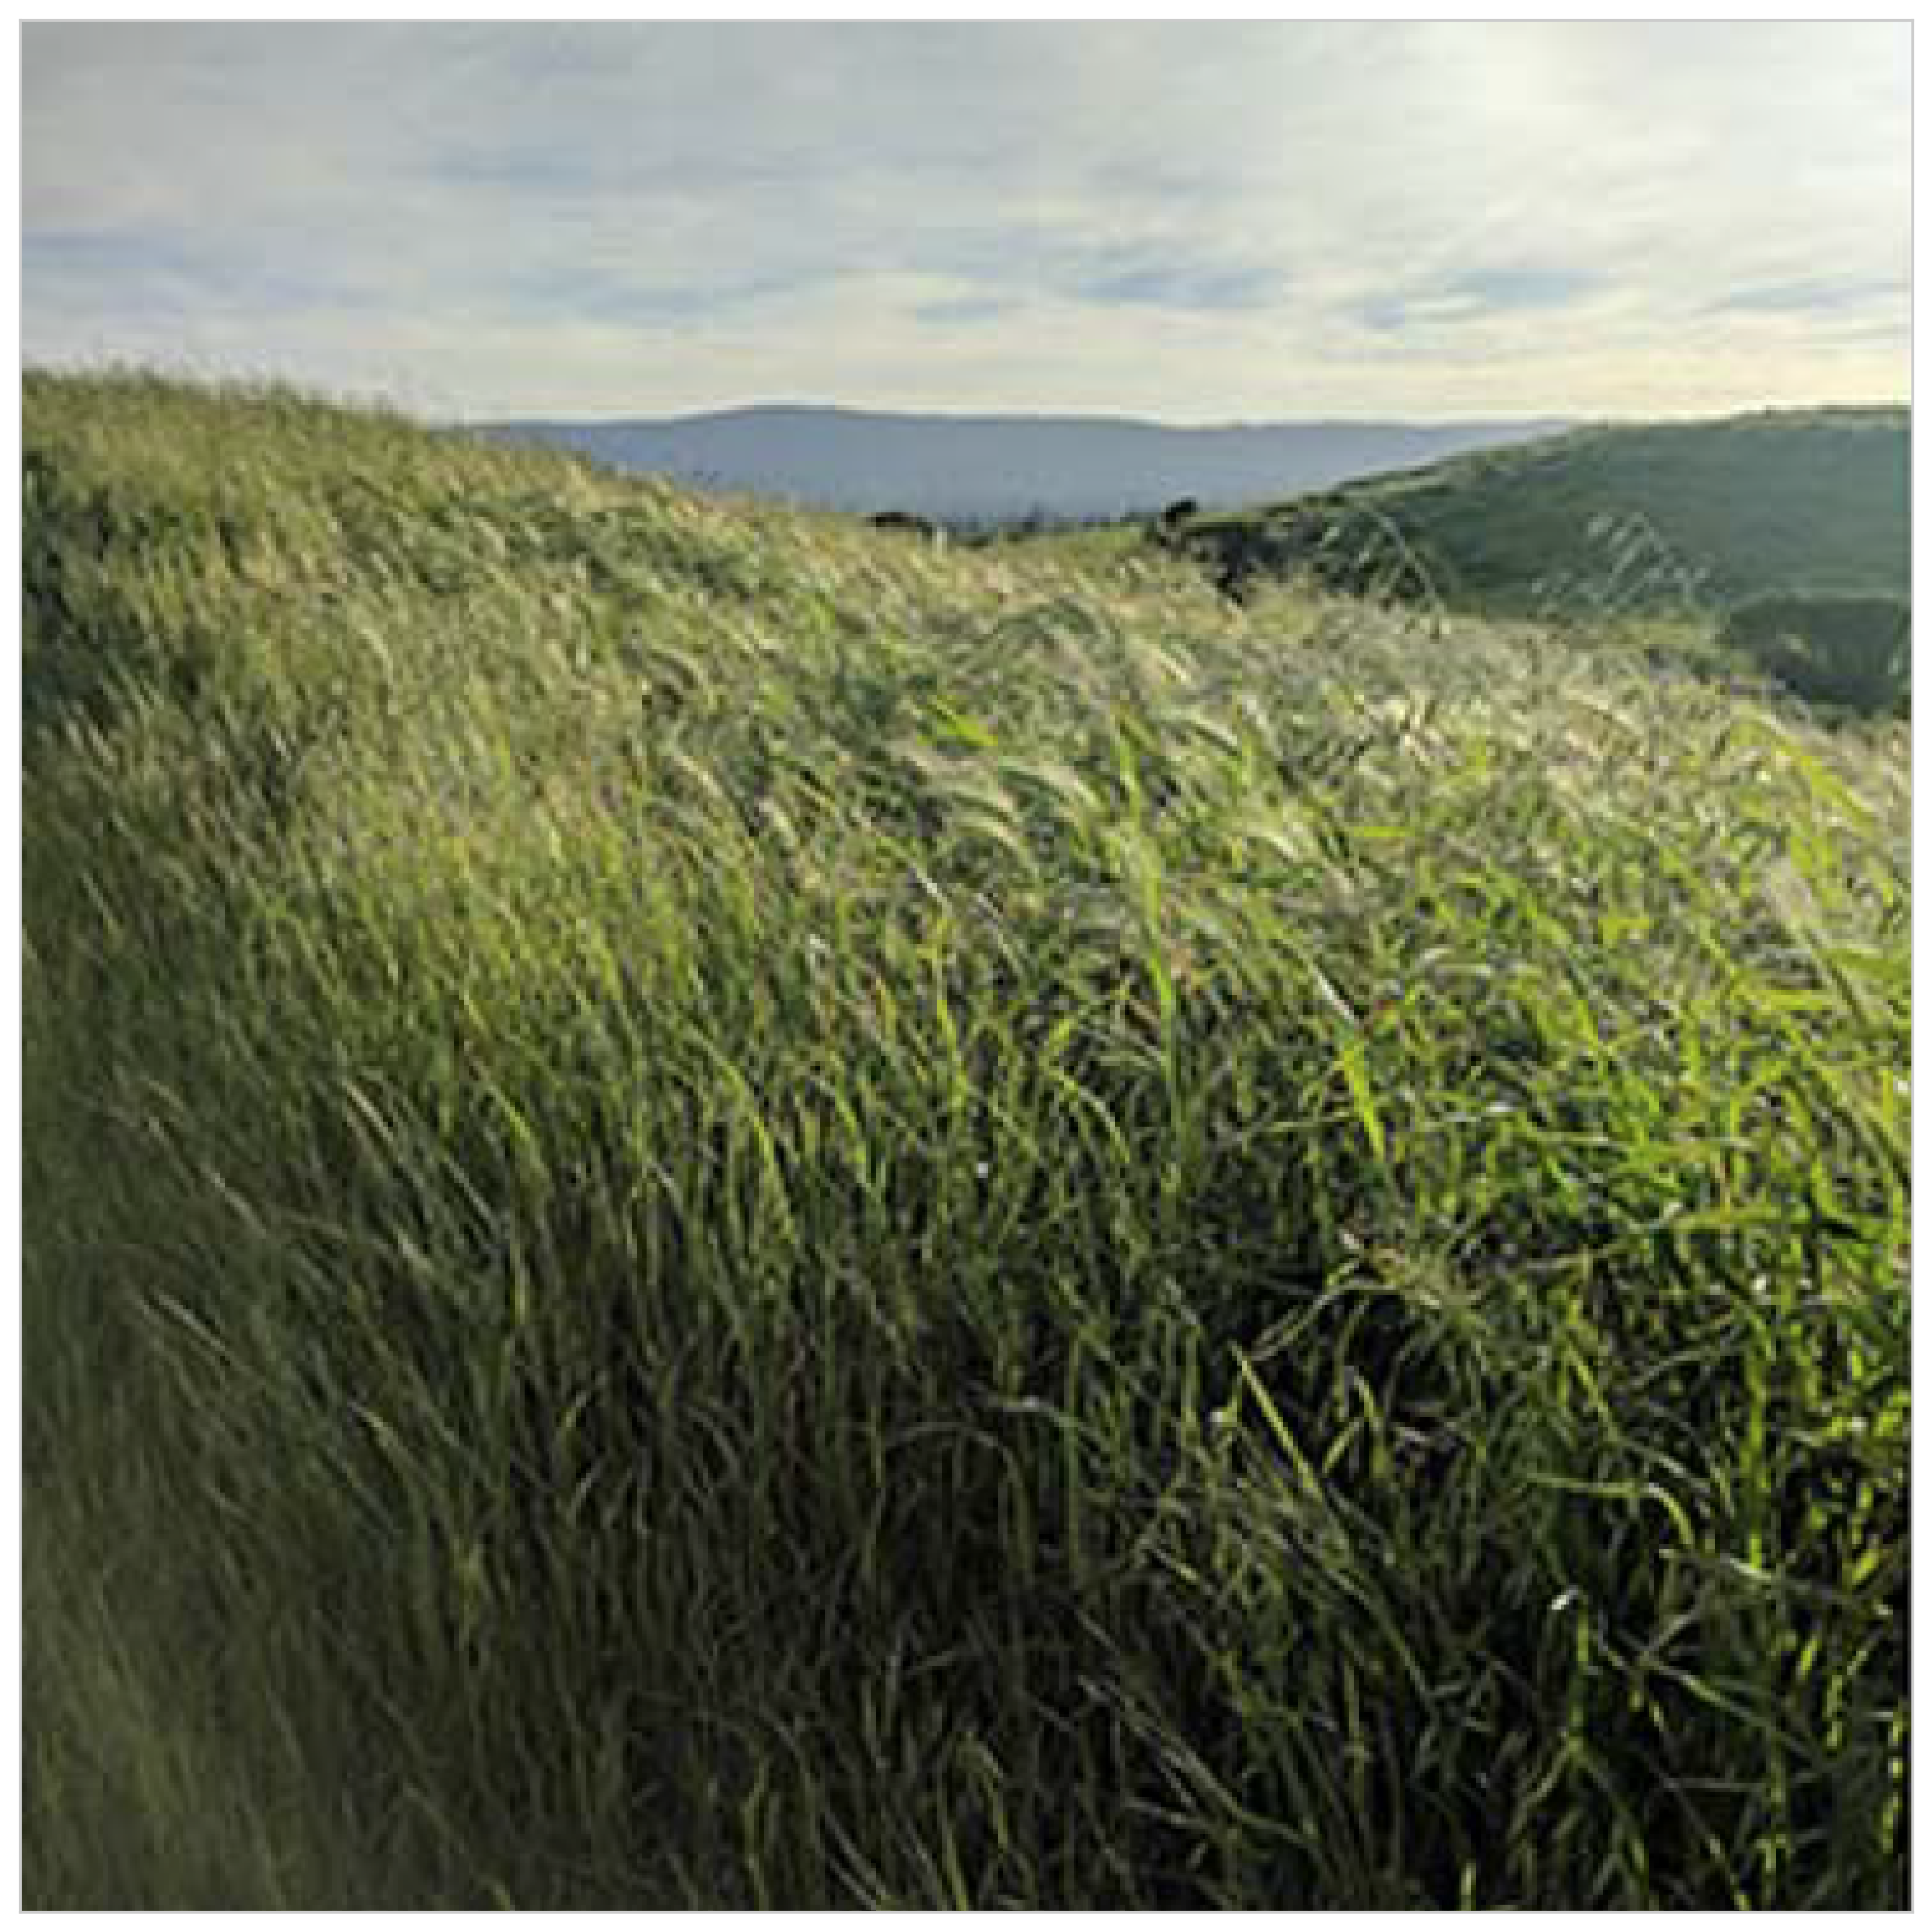

In [4]:
original_image = 'deepdream_parc.png'
final_image = 'cinque_terre_dream.png'

original_image_array = imread(original_image)
show_image(original_image_array)

In [7]:
# Create gaussian pyramid
import warnings
warnings.simplefilter("ignore")
original_image_as_float = img_as_float(original_image_array)
pyramid = list(pyramid_gaussian(original_image_as_float, downscale=2, max_layer=4))

# Convert each image to unsigned byte (0-255)
for i, image in enumerate(pyramid):
    pyramid[i] = img_as_ubyte(pyramid[i])
    print('Image {}) Size: {}'.format(i, pyramid[i].shape))

Image 0) Size: (776, 776, 4)
Image 1) Size: (388, 388, 4)
Image 2) Size: (194, 194, 4)
Image 3) Size: (97, 97, 4)
Image 4) Size: (49, 49, 4)


In [8]:
convnet = inception_v3.InceptionV3(include_top=False, weights='imagenet')

In [11]:
layers = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

image_l2_weight = 0.005

In [12]:

loss_tensor = 0.0

for layer, weight in layers.items():
    loss_tensor += (-weight * K.sum(K.square(convnet.get_layer(layer).output)))
    
loss_tensor += image_l2_weight * K.sum(K.square(convnet.layers[0].input))

_loss_function = K.function(inputs=[convnet.layers[0].input], outputs=[loss_tensor])

In [13]:
loss_gradient = K.gradients(loss=loss_tensor, variables=[convnet.layers[0].input])
_gradient_function = K.function(inputs=[convnet.layers[0].input], outputs=loss_gradient)

In [14]:
def loss(x, shape):
    return _loss_function([x.reshape(shape)])[0]

def gradient(x, shape):
    return _gradient_function([x.reshape(shape)])[0].flatten().astype(np.float64)

In [15]:
def process_image(image, iterations=2):
    # Create bounds
    bounds = np.ndarray(shape=(image.flatten().shape[0], 2))
    bounds[:, 0] = -128.0
    bounds[:, 1] = 128.0

    # Initial value
    x0 = image.flatten()

    # Perform optimization
    result = minimize(fun=loss, 
                      x0=x0, 
                      args=list(image.shape), 
                      jac=gradient, 
                      method='L-BFGS-B', 
                      bounds=bounds, 
                      options={'maxiter': iterations})
    
    return postprocess_image(np.copy(result.x.reshape(image.shape)))


In [17]:
processed_image = None

for i, image in enumerate(pyramid[::-1]):
    print('Processing pyramid image: {} {}'.format(len(pyramid)-i, image.shape))
    
    if processed_image is None:
        processed_image = process_image(preprocess_image(image))
    else:
        h, w = image.shape[0:2]
        ph, pw = processed_image.shape[0:2]
        rescaled_image = rescale(processed_image, order=5, scale=(float(h)/float(ph), float(w)/float(pw)))
        combined_image = img_as_ubyte((1.2*img_as_float(image) + 0.8*rescaled_image) / 2.0)
        processed_image = process_image(preprocess_image(combined_image), iterations=5)

Processing pyramid image: 5 (49, 49, 4)


FailedPreconditionError: Error while reading resource variable conv2d_40/kernel from Container: localhost. This could mean that the variable was uninitialized. Not found: Container localhost does not exist. (Could not find resource: localhost/conv2d_40/kernel)
	 [[{{node conv2d_40/Conv2D/ReadVariableOp}} = ReadVariableOp[dtype=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](conv2d_40/kernel)]]